# Thống kê máy tính và ứng dụng (Computational Statistics and Applications)

## Thông tin sinh viên :
- **Họ và tên :** Trình Cao An  
- **MSSV:** 22127004  

# Các thư viện cần thiết

In [1]:
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from scipy.stats import beta
import pandas as pd

# Câu 1

## Câu 1a
Ta có hàm mật độ xác suất $f(x, y) ∝ e^{-\frac{x^2y^2 + x^2 + y^2 -8x-8y}{2}}$

### 1. Lấy mẫu độc lập.
#### Xác minh điểm cực đại của $f(x, y)$
Để chọn phân phối đề nghị hiệu quả, ta cần xác định hàm mà $f(x, y)$ đạt giá trị lớn nhất, vì đây là vùng tập trung của phân phối mục tiêu. Ta tối ưu hóa hàm:
$$h(x, y) = -\frac{x^2y^2+x^2+y^2 - 8x - 8y}{2}$$
Vì $f(x, y) ∝ e^{h(x, y)}$ nên điểm cực đại của $f(x, y)$ cũng là điểm cực đại của $h(x, y)$.  
Tìm điểm cực đại:
[Kết quả điểm cực đại được tính trên Wolframalpha](https://www.wolframalpha.com/input?i2d=true&i=max%5C%2840%29Power%5Be%2C%5C%2840%29-Divide%5BPower%5Bx%2C2%5DPower%5By%2C2%5D%2BPower%5Bx%2C2%5D%2BPower%5By%2C2%5D-8x-8y%2C2%5D%5C%2841%29%5D%5C%2841%29)  
Ta có:
$$\begin{cases}
(x_1, y_1) = (2 - \sqrt{3}, 2 + \sqrt{3}) \\
(x_2, y_2) = \left(2 + \sqrt{3}, \frac{1}{2 + \sqrt{3}}\right)
\end{cases}$$
#### Chọn phân phối đề nghị
Ta sẽ chọn một phân phối Gaussian đơn với một tâm duy nhất có thể không bao phủ tốt cả hai vùng. Tuy nhiên, để giữ sự đơn giản, chúng ta có thể:
- Tính trung bình $x, y$ của 2 điểm cực đại để làm kỳ vọng:
$$\mu_x = 2, \mu_y ≈ 2$$
- Chọn phương sai $σ_x = σ_y = 1.5$ đủ để bao phủ cả 2 điểm cực đại.

#### Tính hằng số $c$
Để áp dụng Rejection Sampling, ta cần $f(x, y) \leq c · g(x, y)$ cho mọi $(x, y)$. Do đó $c$ phải lơn hơn giá trị lớn nhất của $\frac{f}{g}$

Hằng số c: 651506.7170750515
Tỷ lệ chấp nhận: 0.0313
Tổng số lần thử: 319790
Trung bình X: 1.8336
Trung bình Y: 1.8848
Ma trận hiệp phương sai:
 [[ 2.7560169  -2.32981251]
 [-2.32981251  2.80929154]]


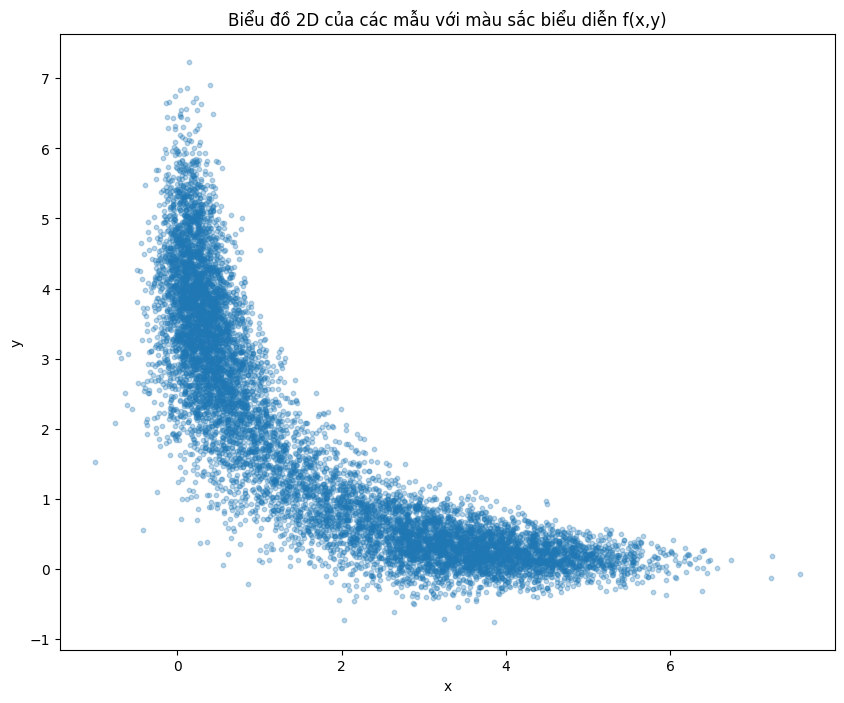

In [2]:
# Hàm Rejection Sampling
def ESR_2D(N, f, gs, g, c):
    T = 0       # Tổng số lần thử
    X = []      # Danh sách lưu mẫu
    i = 0       # Số mẫu đã chấp nhận
    while i < N:
        T += 1
        x, y = gs()
        U = np.random.uniform()  # Sinh U ~ U(0,1)
        if c * g(x, y) * U <= f(x, y):
            X.append([x, y])
            i += 1
    return np.array(X), T

# Hàm mật độ mục tiêu
def f_target(x, y):
    return np.exp(-(x**2 * y**2 + x**2 + y**2 - 8*x - 8*y) / 2)

# Hàm mật độ đề nghị: Gaussian đơn
def g_proposal(x, y, mu_x=2.0, mu_y=2.0, sigma_x=1.5, sigma_y=1.5):
    gx = (1/(np.sqrt(2*np.pi)*sigma_x)) * np.exp(-((x - mu_x)**2)/(2*sigma_x**2))
    gy = (1/(np.sqrt(2*np.pi)*sigma_y)) * np.exp(-((y - mu_y)**2)/(2*sigma_y**2))
    return gx * gy

# Sinh mẫu từ đề nghị
def gs_proposal(mu_x=2.0, mu_y=2.0, sigma_x=1.5, sigma_y=1.5):
    x = np.random.normal(loc=mu_x, scale=sigma_x)
    y = np.random.normal(loc=mu_y, scale=sigma_y)
    return x, y

# Tính hằng số c
n_points = 1000000
x_samples = np.random.normal(loc=2.0, scale=1.5, size=n_points)
y_samples = np.random.normal(loc=2.0, scale=1.5, size=n_points)
f_values = f_target(x_samples, y_samples)
g_values = g_proposal(x_samples, y_samples)
c = 1.1 * np.max(f_values / g_values)  # Nhân 1.1 để đảm bảo an toàn
print(f"Hằng số c: {c}")
# Thiết lập seed
np.random.seed(2022)

# Số mẫu cần lấy
N = 10000

# Lấy mẫu
samples, total_attempts = ESR_2D(N, f_target, gs_proposal, g_proposal, c)

# Kết quả
print(f"Tỷ lệ chấp nhận: {N / total_attempts:.4f}")
print(f"Tổng số lần thử: {total_attempts}")
print(f"Trung bình X: {np.mean(samples[:, 0]):.4f}")
print(f"Trung bình Y: {np.mean(samples[:, 1]):.4f}")
print("Ma trận hiệp phương sai:\n", np.cov(samples.T))


z_values = np.array([f_target(x, y) for x, y in samples])

# Tạo biểu đồ 2D
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(samples[:, 0], samples[:, 1], alpha=0.3, s=10)
ax.set_title("Biểu đồ 2D của các mẫu với màu sắc biểu diễn f(x,y)")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

### 2. Metropolis-Hastings (hoặc Metropolis)
Hàm mật độ mục tiêu của chúng ta là:
$$f(x, y) = e^{-\frac{x^2y^2+x^2+y^2 - 8x - 8y}{2}}$$
Vì đây là dạng không phải chuẩn hóa, Metropolis-Hastings là lựa chọn phù hợp.  
Phân phối đề nghị sử dụng : Sử dụng phân phối Gaussian đối xứng $q(x',y'|x, y) = 𝓝(x, σ^2) \times 𝓝(y, σ^2)$, với $σ$ là độ lệch chuẩn của bước nhảy.  
Tỷ lệ chấp nhận : Vì $q$ đối xứng, tỷ lệ chấp nhận đơn giản hóa thành $α = \min\left(1, \frac{f(x', y')}{f(x, y)}\right)$.  


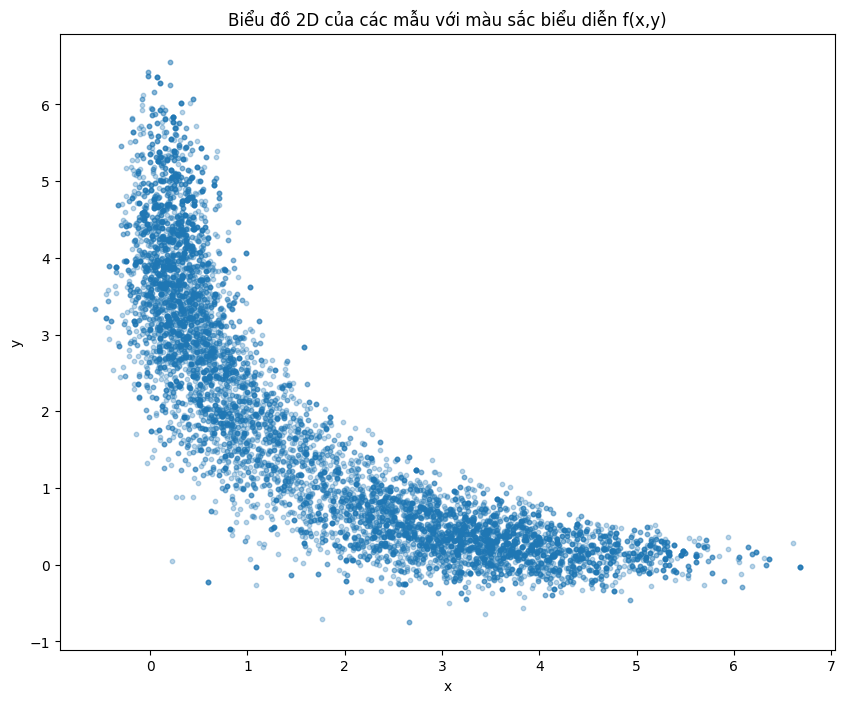

In [3]:
# Thuật toán Metropolis-Hastings
def metropolis_hastings(N, sigma, x0, y0):
    samples = []
    x, y = x0, y0
    for _ in range(N):
        # Sinh điểm đề nghị từ Gaussian
        x_prime = x + np.random.normal(0, sigma)
        y_prime = y + np.random.normal(0, sigma)

        # Tính tỷ lệ chấp nhận
        alpha = min(1, f_target(x_prime, y_prime) / f_target(x, y))

        # Chấp nhận hoặc từ chối
        if np.random.uniform(0, 1) < alpha:
            x, y = x_prime, y_prime

        samples.append([x, y])
    return np.array(samples)

# Tham số
N = 10000  # Số lượng mẫu
sigma = 0.5  # Bước nhảy
x0, y0 = 2, 2  # Điểm khởi đầu

# Chạy thuật toán
samples = metropolis_hastings(N, sigma, x0, y0)

# Tạo biểu đồ 2D
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(samples[:, 0], samples[:, 1], alpha=0.3, s=10)
ax.set_title("Biểu đồ 2D của các mẫu với màu sắc biểu diễn f(x,y)")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()


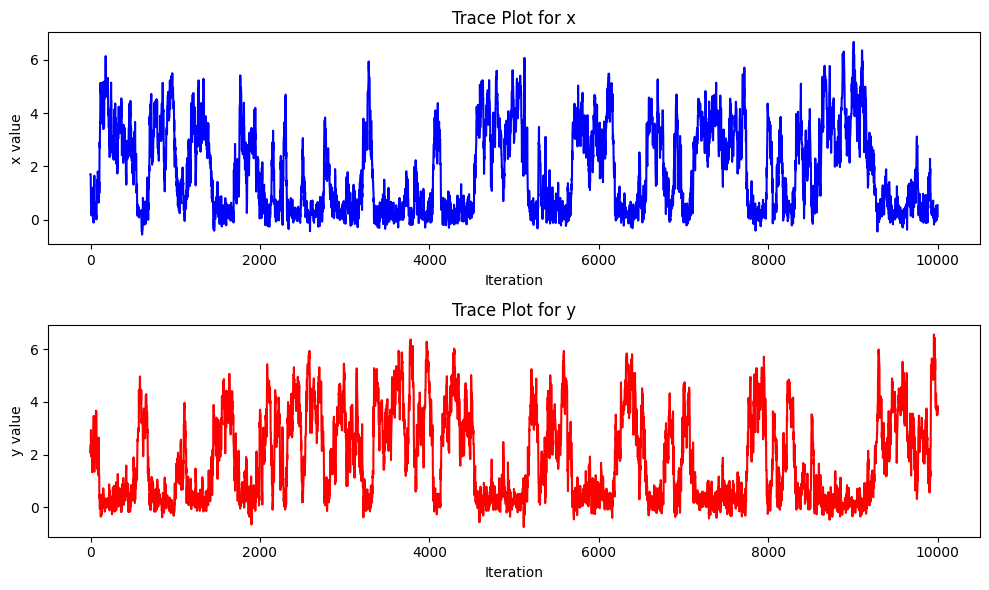

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
# Trace plot cho x
axs[0].plot(samples[:, 0], color='blue')
axs[0].set_title('Trace Plot for x')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('x value')

# Trace plot cho y
axs[1].plot(samples[:, 1], color='red')
axs[1].set_title('Trace Plot for y')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('y value')

plt.tight_layout()
plt.show()


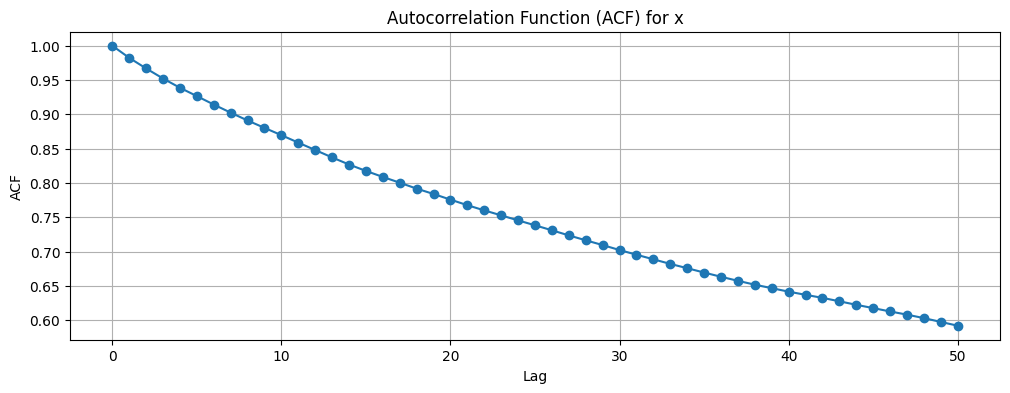

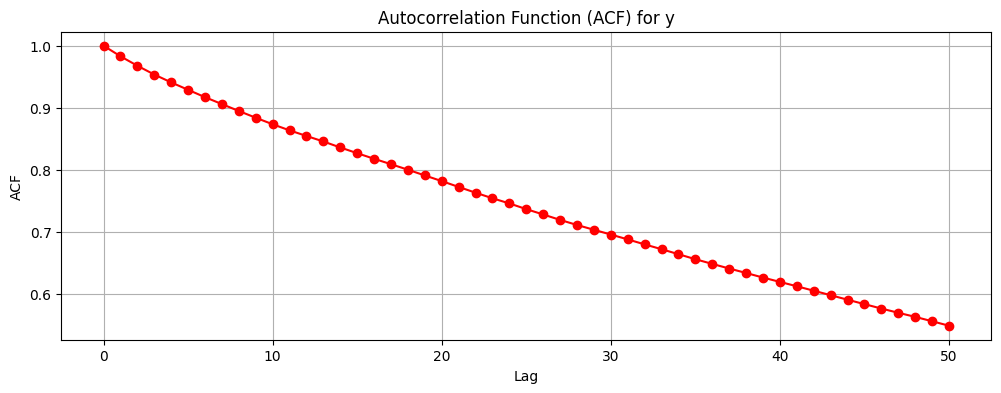

In [5]:
acf_x = sm.tsa.acf(samples[:, 0], nlags=50, fft = True)
acf_y = sm.tsa.acf(samples[:, 1], nlags=50, fft = True)
# In ra giá trị ACF
# print("ACF cho x:", acf_x)
# print("ACF cho y:", acf_y)
# Vẽ biểu đồ ACF cho x
plt.figure(figsize=(12, 4))
plt.plot(acf_x, marker='o')
plt.title("Autocorrelation Function (ACF) for x")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.grid(True)
plt.show()

# Vẽ biểu đồ ACF cho y
plt.figure(figsize=(12, 4))
plt.plot(acf_y, marker='o', color='red')
plt.title("Autocorrelation Function (ACF) for y")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.grid(True)
plt.show()

### 3. Lấy mẫu Gibbs
Để áp dụng Gibbs Sampling, chúng ta cần tính các phân phối có điều kiện $p(x|y)$ và $p(y|x)$ từ $f(x, y)$.  
1. Tính $p(x|y)$  
Khi coi $y$ là hắng số ta có:
$$p(x|y) ∝ e^{-\frac{x^2y^2 + x^2 - 8x}{2}} = e^{-\frac{y^2 + 1}{2}
\left(x - \frac{4}{y^2 + 1}\right) + c}$$
Đây là phân phối Gaussian với:
  - Kỳ vọng : $\mu_x = \frac{4}{y^2 + 1}$
  - Phương sai : $σ^2_x = \frac{4}{y^2 + 1}$.  
Vậy:
$$x|y ∼ 𝓝\left(\frac{4}{y^2 + 1}, \frac{4}{y^2 + 1}\right)$$.
2. Tính $p(y|x)$  
Khi coi $x$ là hằng số ta có:
$$p(y|x) ∝ e^{-\frac{x^2y^2 + y^2 - 8y}{2}}$$
Tương tự như trên ta có:
$$y|x ∼ 𝓝\left(\frac{4}{x^2 + 1}, \frac{4}{x^2 + 1}\right)$$.


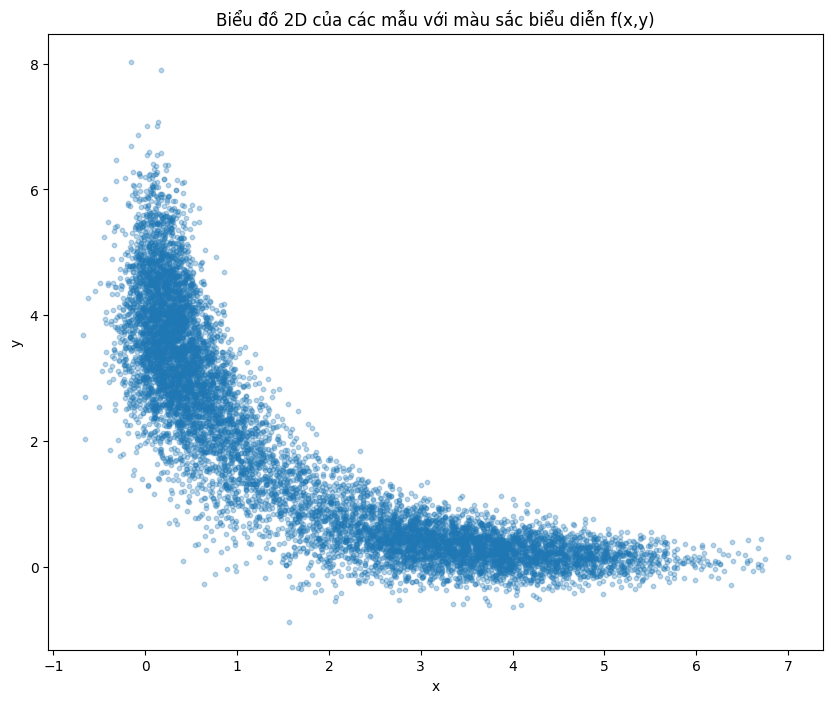

In [6]:
def gibbs_sampling(N, x0, y0):
    samples = []
    x, y = x0, y0
    for _ in range(N):
        # Lấy mẫu x từ p(x | y)
        mu_x = 4 / (y**2 + 1)
        sigma_x = np.sqrt(1 / (y**2 + 1))
        x = np.random.normal(mu_x, sigma_x)

        # Lấy mẫu y từ p(y | x)
        mu_y = 4 / (x**2 + 1)
        sigma_y = np.sqrt(1 / (x**2 + 1))
        y = np.random.normal(mu_y, sigma_y)

        samples.append([x, y])
    return np.array(samples)

# Tham số
N = 10000  # Số lượng mẫu
x0, y0 = 2, 2  # Giá trị khởi đầu

# Chạy Gibbs Sampling
samples = gibbs_sampling(N, x0, y0)

# Tạo biểu đồ 2D
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(samples[:, 0], samples[:, 1], alpha=0.3, s=10)
ax.set_title("Biểu đồ 2D của các mẫu với màu sắc biểu diễn f(x,y)")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()



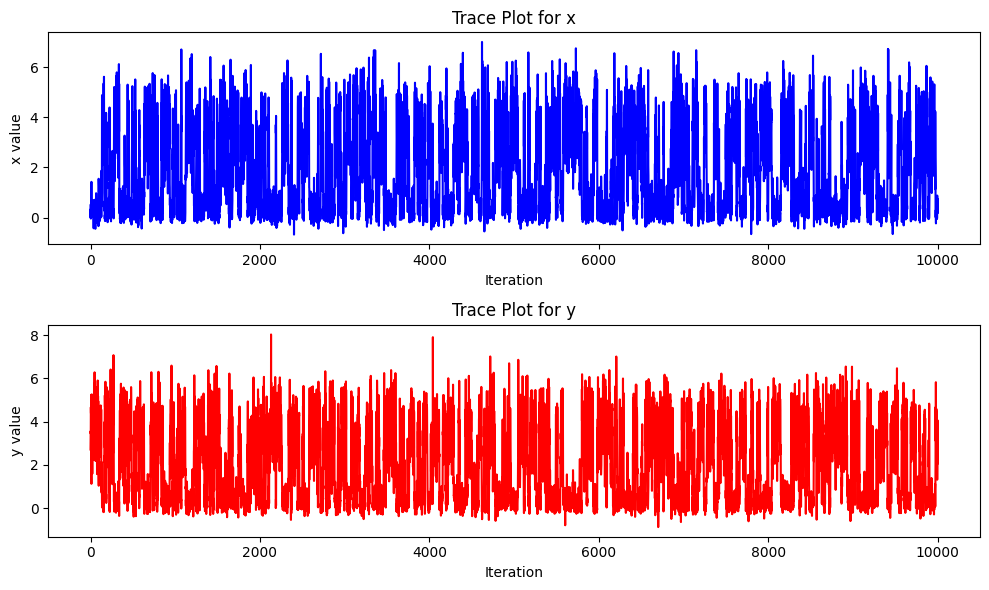

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Trace plot cho x
axs[0].plot(samples[:, 0], color='blue')
axs[0].set_title('Trace Plot for x')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('x value')

# Trace plot cho y
axs[1].plot(samples[:, 1], color='red')
axs[1].set_title('Trace Plot for y')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('y value')

plt.tight_layout()
plt.show()

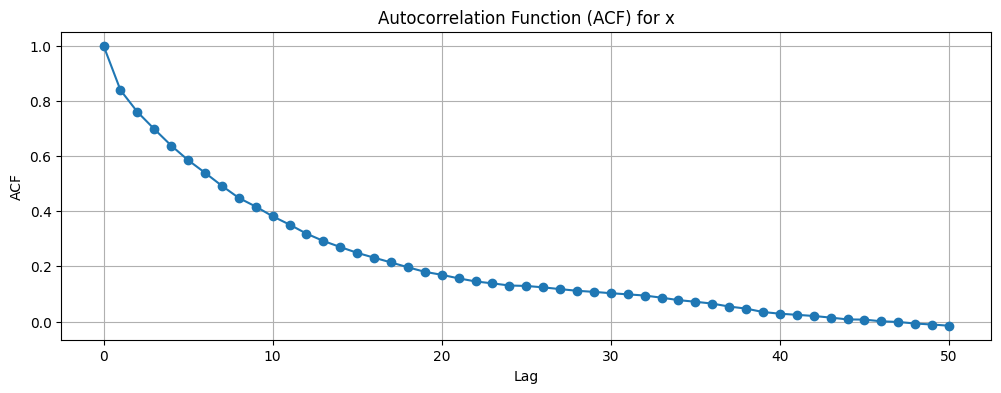

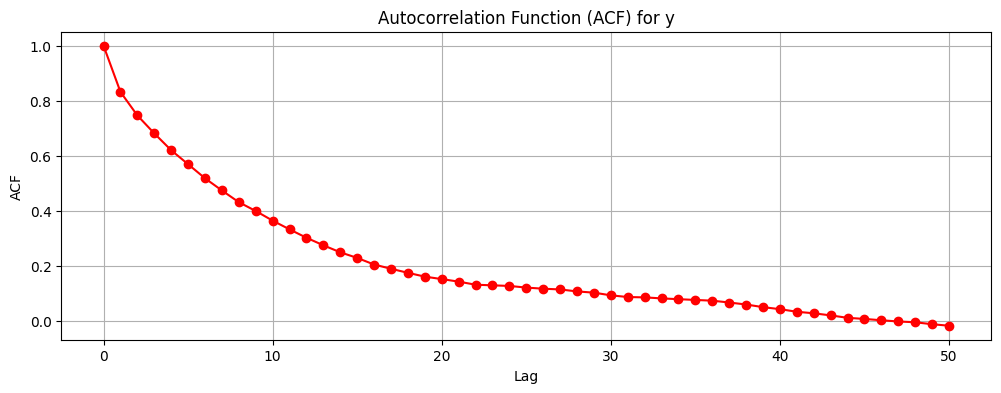

In [8]:
acf_x = sm.tsa.acf(samples[:, 0], nlags=50, fft = True)
acf_y = sm.tsa.acf(samples[:, 1], nlags=50, fft = True)
# In ra giá trị ACF
# print("ACF cho x:", acf_x)
# print("ACF cho y:", acf_y)
# Vẽ biểu đồ ACF cho x
plt.figure(figsize=(12, 4))
plt.plot(acf_x, marker='o')
plt.title("Autocorrelation Function (ACF) for x")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.grid(True)
plt.show()

# Vẽ biểu đồ ACF cho y
plt.figure(figsize=(12, 4))
plt.plot(acf_y, marker='o', color='red')
plt.title("Autocorrelation Function (ACF) for y")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.grid(True)
plt.show()

## 1b. So sánh các phương pháp ở câu a


### Phương pháp ESR với Acceptance-Rejection (Lấy mẫu độc lập)
Ưu điểm:
- Mẫu độc lập: Mỗi mẫu được sinh ra hoàn toàn độc lập với nhau, không có “dính” thông tin từ mẫu trước đó.
- Dễ hiểu và cài đặt: Ý tưởng rất đơn giản và dễ hình dung.  

Nhược điểm:
- Hiệu quả thấp nếu c quá cao: Nếu hằng số c lớn, có thể phải thử rất nhiều lần (T được tăng rất nhiều) mới có đủ mẫu chấp nhận, dẫn đến tốn thời gian tính toán.
- Phụ thuộc vào việc chọn đúng phân phối đề nghị: Nếu phân phối đề nghị không “đủ tốt” để gần với phân phối mục tiêu, tỷ lệ mẫu bị loại sẽ cao.

### Thuật toán Metropolis-Hastings
Ưu điểm:
- Linh hoạt: Không cần phải tính toán hằng số c.
- Có thể áp dụng cho nhiều trường hợp: Dù phân phối mục tiêu có hình dạng phức tạp, M-H vẫn có thể hoạt động.  

Nhược điểm:
- Tự tương quan giữa các mẫu: Các mẫu liên tiếp có thể “dính” vào nhau, cần thêm bước “burn-in” (loại bỏ một số mẫu đầu) để đảm bảo chuỗi đã hội tụ.
- Cần tinh chỉnh tham số (như sigma): Nếu bước nhảy quá lớn hoặc quá nhỏ, chuỗi có thể không “di chuyển” hiệu quả qua không gian mẫu.

### Thuật toán Gibbs Sampling
Ưu điểm:
- Dễ dàng lấy mẫu từ các phân phối điều kiện: Nếu em có các công thức rõ ràng cho phân phối điều kiện, việc cập nhật sẽ rất nhanh và hiệu quả.
- Hội tụ nhanh nếu phân phối điều kiện đơn giản: Khi điều kiện dễ lấy mẫu, chuỗi có thể “trộn” nhanh và cho kết quả ổn định.

Nhược điểm:
- Không phải lúc nào cũng áp dụng được: Nếu không thể tính được phân phối điều kiện của từng biến, Gibbs Sampling sẽ không thực hiện được.
- Có thể bị “kẹt” nếu các biến phụ thuộc mạnh: Khi sự phụ thuộc giữa các biến quá cao, mỗi bước cập nhật chỉ thay đổi rất ít nên chuỗi chuyển động chậm.

### Kết luận
Về thời gian đo 3 thuật toán ta thấy Gibbs Sampling và MH đang làm tốt hơn so với phương pháp lấy mẫu độc lập.
So sánh 2 thuật toán Gibbs Sampling và MH ta cũng thấy rằng Gibb đang cho ra mẫu độc lập hơn (dựa vào biểu đồ ACF và trace).
Vì vậy ở câu a thuật toán hoạt động tốt nhất là Gibbs Sampling.

## 1c Ước lượng xác suất $P(X \leq Y) $ và kỳ vọng $E(XY)$ (có đánh giá sai số).

In [9]:
# Thiết lập tham số
N = 100000      # Số lượng mẫu
x0, y0 = 2, 2  # Giá trị khởi đầu

# Chạy Gibbs Sampling
samples = gibbs_sampling(N, x0, y0)


# Ước lượng P(X >= Y)
indicator = samples[:, 0] >= samples[:, 1]
P_est = np.mean(indicator)
# Tính sai số chuẩn (standard error) cho tỷ lệ nhị phân:
se_P = np.sqrt(P_est * (1 - P_est) / len(indicator))

# Ước lượng E(XY)
XY = samples[:, 0] * samples[:, 1]
E_est = np.mean(XY)
se_E = np.std(XY, ddof=1) / np.sqrt(len(XY))

# Tính khoảng tin cậy 95% cho P(X >= Y)
CI_lower_P = P_est - 1.96 * se_P
CI_upper_P = P_est + 1.96 * se_P

# Tính khoảng tin cậy 95% cho E(XY)
CI_lower_E = E_est - 1.96 * se_E
CI_upper_E = E_est + 1.96 * se_E

print("95% Confidence Interval for P(X >= Y): [{:.4f}, {:.4f}]".format(CI_lower_P, CI_upper_P))
print("95% Confidence Interval for E(XY): [{:.4f}, {:.4f}]".format(CI_lower_E, CI_upper_E))


95% Confidence Interval for P(X >= Y): [0.4979, 0.5040]
95% Confidence Interval for E(XY): [1.1267, 1.1386]


# Câu 2

## 2a. Không biết thông tin gì cả

Lựa chọn tiên nghiệm:
- Chọn $p \sim Beta(1, 1)$ (do không có thông tin gì cả nên $p \in [0, 1]$)
- Dữ liệu $n = 10, z = 8$
- Likelihood : $y \sim Binomial(n = 10, p)$ với $y = 8$
- Posterior với tiên nghiệm $Beta(1, 1)$ và dữ liệu sẽ là:
$$p | y \sim Beta(9, 3)$$

Output()

   mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
p  0.75  0.122     0.518       0.96      0.003    0.002    1549.0    1535.0   

   r_hat  
p    1.0  


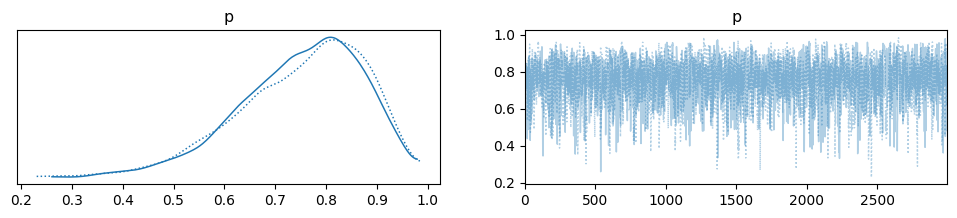

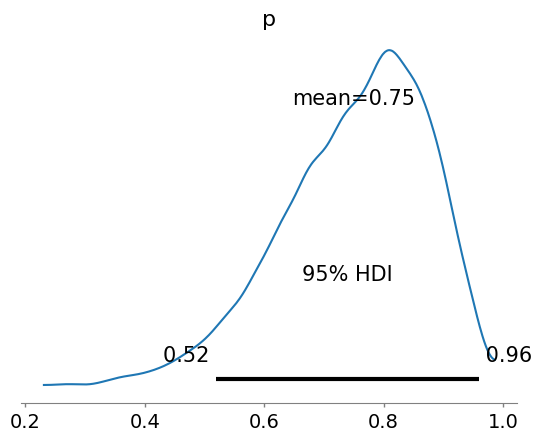

In [10]:
# Xây dựng mô hình Bayesian
with pm.Model() as coin_model:
    # Prior: p ~ Beta(1,1) (Uniform trên [0,1])
    p = pm.Beta("p", alpha=1, beta=1)

    # Likelihood: Sử dụng phân phối Binomial
    # Tung đồng xu 10 lần, quan sát thấy 8 lần ra ngửa.
    y_obs = pm.Binomial("y_obs", n=10, p=p, observed=8)

    # Lấy mẫu posterior: sử dụng thuật toán MCMC (NUTS là mặc định)
    trace = pm.sample(draws=3000, tune=1000, chains=2, random_seed=42, target_accept=0.95)

# Tóm tắt kết quả
summary = az.summary(trace, var_names=["p"], hdi_prob=0.95)
print(summary)

# Vẽ trace plot và phân phối posterior của p
az.plot_trace(trace, var_names=["p"])
plt.show()

az.plot_posterior(trace, var_names=["p"], hdi_prob=0.95)
plt.show()


In [11]:
# Tính xác suất p > 0.6 từ các mẫu
p_samples = trace.posterior["p"].values.flatten()
prob_gt_06 = np.mean(p_samples > 0.6)
print(f"P(p > 0.6) ≈ {prob_gt_06:.4f}")

P(p > 0.6) ≈ 0.8785


**Kết luận** : ước lượng tốt nhất cho $p$ là khoảng 0.75 và khả năng $p > 0.6$ là rất cao dựa trên mô hình Bayes này.

## 2b. Đồng xu có khả năng cân đối cao ($p$ quanh 0.5)

Lựa chọn tiên nghiệm:
- Chọn $p \sim Beta(5, 5)$ (do đồng xu có khả năng cân đối cao và $p$ quanh 0.5)
- Dữ liệu $n = 10, z = 8$
- Likelihood : $y \sim Binomial(n = 10, p)$ với $y = 8$
- Posterior với tiên nghiệm $Beta(1, 1)$ và dữ liệu sẽ là:
$$p | y \sim Beta(13, 7)$$

Output()

    mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
p  0.649  0.104     0.442      0.843      0.002    0.002    2268.0    2280.0   

   r_hat  
p    1.0  


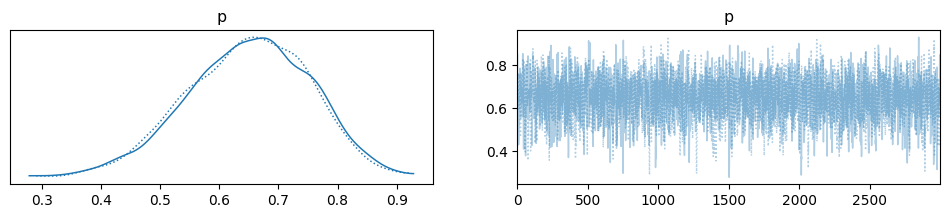

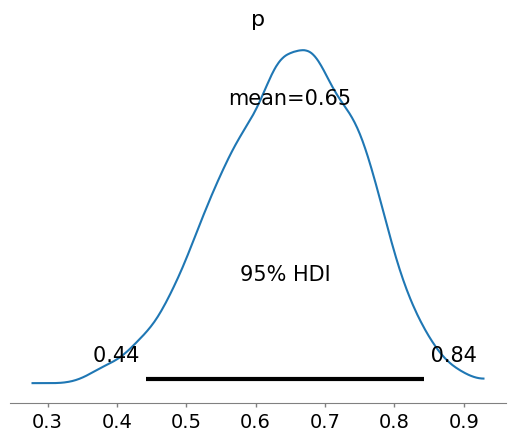

In [12]:
# Xây dựng mô hình với tiên nghiệm Beta(5,5)
with pm.Model() as coin_model_b:
    # Prior: p ~ Beta(5,5) - tập trung quanh 0.5
    p = pm.Beta("p", alpha=5, beta=5)

    # Likelihood: Quan sát 8 lần ra ngửa trong 10 lần tung
    y_obs = pm.Binomial("y_obs", n=10, p=p, observed=8)

    # Lấy mẫu posterior: dùng MCMC (NUTS được chọn mặc định)
    trace_b = pm.sample(draws=3000, tune=1000, chains=2, random_seed=42, target_accept=0.95)

# Tóm tắt kết quả
summary_b = az.summary(trace_b, var_names=["p"], hdi_prob=0.95)
print(summary_b)

# Vẽ trace plot và posterior plot cho p
az.plot_trace(trace_b, var_names=["p"])
plt.show()

az.plot_posterior(trace_b, var_names=["p"], hdi_prob=0.95)
plt.show()


In [13]:
# Tính xác suất p > 0.6 từ các mẫu
p_samples = trace_b.posterior["p"].values.flatten()
prob_gt_06 = np.mean(p_samples > 0.6)
print(f"P(p > 0.6) ≈ {prob_gt_06:.4f}")

P(p > 0.6) ≈ 0.6868


**Kết luận** : $p ≈ 0.65$ và xác suất $p > 0.6$ cũng tương đối cao.

## 2c. Đồng xu có khả năng mất cân đối cao ($p$ quanh 0 hoặc 1)

Với tiên nghiệm “đồng xu có khả năng mất cân đối cao” (nghĩa là trước khi quan sát dữ liệu, ta tin rằng $p$ có xu hướng gần 0 hoặc 1). Để thể hiện niềm tin này ta chọn tiên nghiệm $p \sim Beta(0.5, 0.5)$.  
Tương tự như trên ta có:
$$p | y \sim Beta(8.5, 2.5)$$

Output()

    mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
p  0.772  0.123     0.532      0.975      0.003    0.002    2105.0    1997.0   

   r_hat  
p    1.0  


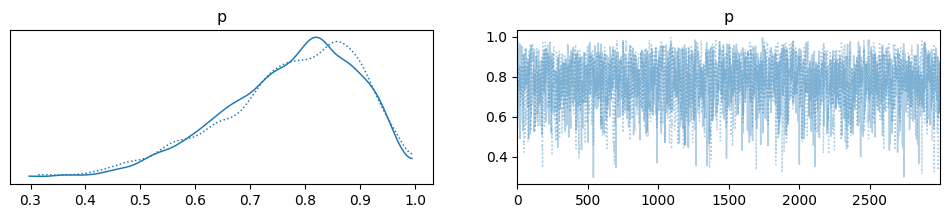

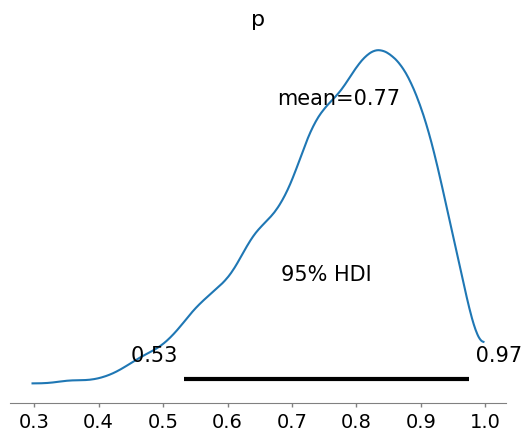

P(p > 0.6) ≈ 0.8957


In [14]:
# Xây dựng mô hình với tiên nghiệm Beta(0.5, 0.5)
with pm.Model() as coin_model_c:
    # Prior: p ~ Beta(0.5, 0.5) thể hiện niềm tin rằng đồng xu có khả năng mất cân đối (U-shaped)
    p = pm.Beta("p", alpha=0.5, beta=0.5)

    # Likelihood: Tung đồng xu 10 lần, quan sát 8 lần ngửa
    y_obs = pm.Binomial("y_obs", n=10, p=p, observed=8)

    # Lấy mẫu posterior bằng MCMC (sử dụng thuật toán NUTS mặc định)
    trace_c = pm.sample(draws=3000, tune=1000, chains=2, random_seed=42, target_accept=0.95)

# Tóm tắt kết quả posterior của p
summary_c = az.summary(trace_c, var_names=["p"], hdi_prob=0.95)
print(summary_c)

# Vẽ trace plot cho kiểm tra hội tụ
az.plot_trace(trace_c, var_names=["p"])
plt.show()

# Vẽ phân phối posterior của p kèm khoảng HDI 95%
az.plot_posterior(trace_c, var_names=["p"], hdi_prob=0.95)
plt.show()

# Tính xác suất p > 0.6 từ các mẫu
p_samples = trace_c.posterior["p"].values.flatten()
prob_gt_06 = np.mean(p_samples > 0.6)
print(f"P(p > 0.6) ≈ {prob_gt_06:.4f}")

**Kết luận :** $p ≈ 0.772$ và xác suất $p > 0.6$ rất cao.

## 2d. $p$ chỉ nhận 1 trong 3 giá trị 0.2, 0.7, 0.9

Ta chọn tiên nghiệm đồng đều trên 3 giá trị:
$$P(p = 0.2) = P(p = 0.7) = P(p = 0.9) = \frac{1}{3}$$

Output()

    mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
p  0.787  0.099       0.7        0.9      0.003      0.0    1492.0    1492.0   

   r_hat  
p    1.0  


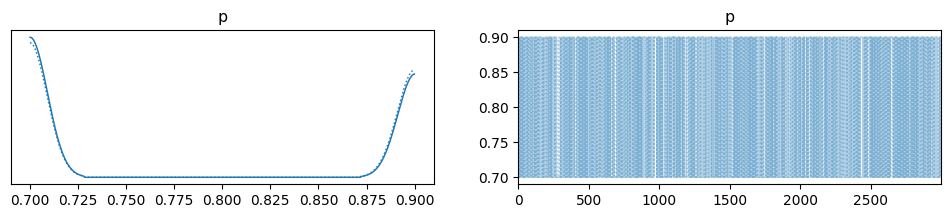

Posterior probabilities:
p = 0.2: 0.0000
p = 0.7: 0.5657
p = 0.9: 0.4343
Posterior mean of p ≈ 0.7869
P(p > 0.6) ≈ 1.0000


In [15]:
# Danh sách các giá trị mà p có thể nhận
p_values = np.array([0.2, 0.7, 0.9])

with pm.Model() as model_d:
    # Biến rời rạc: index, có 3 giá trị với tiên nghiệm đồng đều
    index = pm.Categorical("index", p= 1/3 * np.ones(3))

    # Định nghĩa p dựa trên index: nếu index==0 thì p=0.2, index==1 thì p=0.7, index==2 thì p=0.9
    p = pm.Deterministic(
    "p",
    pt.switch(
        pt.eq(index, 0),
        p_values[0],
        pt.switch(pt.eq(index, 1), p_values[1], p_values[2])
    )
)

    # Likelihood: Tung đồng xu 10 lần, quan sát 8 lần ngửa
    y_obs = pm.Binomial("y_obs", n=10, p=p, observed=8)

    # Vì có biến rời rạc, ta sử dụng Metropolis sampler
    trace_d = pm.sample(draws=3000, tune=1000, chains=2, step=pm.Metropolis(), random_seed=42)

# Tóm tắt kết quả
summary_d = az.summary(trace_d, var_names=["p"], hdi_prob=0.95)
print(summary_d)

# Vẽ trace plot của p
az.plot_trace(trace_d, var_names=["p"])
plt.show()

# Lấy các mẫu của p (do p chỉ nhận 3 giá trị, chúng ta có thể tính xác suất hậu nghiệm)
p_samples = trace_d.posterior["p"].values.flatten()

# Đếm số mẫu tương ứng với mỗi giá trị
unique, counts = np.unique(p_samples, return_counts=True)
posterior_probs = dict(zip(unique, counts/len(p_samples)))
print("Posterior probabilities:")
for val in p_values:
    print(f"p = {val:.1f}: {posterior_probs.get(val, 0):.4f}")

# Ước lượng trung bình posterior của p
posterior_mean = np.sum(np.array(list(posterior_probs.keys())) * np.array(list(posterior_probs.values())))
print(f"Posterior mean of p ≈ {posterior_mean:.4f}")

# Tính xác suất p > 0.6: chỉ các giá trị 0.7 và 0.9
prob_gt_06 = posterior_probs.get(0.7, 0) + posterior_probs.get(0.9, 0)
print(f"P(p > 0.6) ≈ {prob_gt_06:.4f}")

**Kết luận :** Theo mô hình rời rạc này xác suất $p = 0.7 $ là $≈ 0.5657$, xác suất $p = 0.9$ là $≈ 0.4343$ gần $0$ cho $p = 0.2$. Và xác suất $p > 0.6$ xấp xỉ 1.

## 2e. $p$ chỉ nhận giá trị trong khoảng [0.4,0.9]

Ta chọn tiên nghiệm là phân phối đều từ $[0.4 , 0.9]$

Output()

    mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
p  0.772  0.123     0.532      0.975      0.003    0.002    2105.0    1997.0   

   r_hat  
p    1.0  


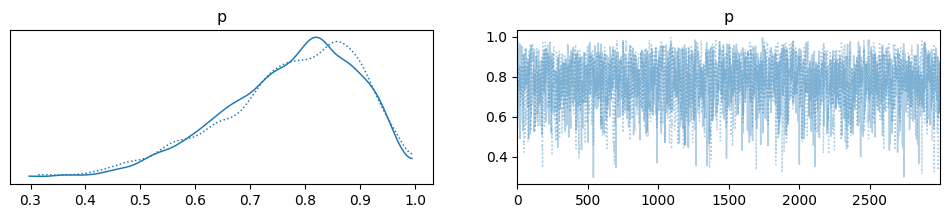

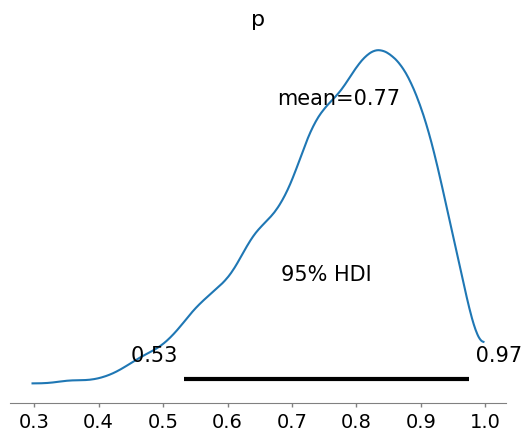

P(p > 0.6) ≈ 0.8957


In [16]:

with pm.Model() as model_e:
    # Prior: p ~ Uniform(0.4, 0.9)
    p = pm.Uniform("p", lower=0.4, upper=0.9)

    # Likelihood: k ~ Binomial(n=n, p=p)
    obs = pm.Binomial("obs", n=10, p=p, observed=8)

    # Lấy mẫu posterior
    trace_e = pm.sample(draws=3000, tune=1000, chains=2, random_seed=42, target_accept=0.9)

# Tóm tắt kết quả posterior của p
summary_e = az.summary(trace_e, var_names=["p"], hdi_prob=0.95)
print(summary_e)

# Vẽ trace plot cho kiểm tra hội tụ
az.plot_trace(trace_e, var_names=["p"])
plt.show()

# Vẽ phân phối posterior của p kèm khoảng HDI 95%
az.plot_posterior(trace_e, var_names=["p"], hdi_prob=0.95)
plt.show()

# Tính xác suất p > 0.6 từ các mẫu
p_samples = trace_e.posterior["p"].values.flatten()
prob_gt_06 = np.mean(p_samples > 0.6)
print(f"P(p > 0.6) ≈ {prob_gt_06:.4f}")


**Kết luận:** Theo mô hình trên phân tích được thì giá trị kì vọng của $p ≈ 0.77$ và xác suất $p > 0.6$ rất cao $≈ 0.8957$

# Câu 3:

Mục tiêu:

Sau khi quan sát $Z = 4$, ta muốn suy ra (inference) về $X$ và đặc biệt là xác suất $P(X \geq 3 | Z = 4)$.  
Cấu trúc phân phối chung:  
Biến $X$ có phân phối tiên nghiệm $f_X(x) = N(0, 2^2)$. Sau đó với mỗi giá trị $x$ thì $Y \sim \text{Uniform}(0, |x|)$. Và cuối cùng $Z$ có phân phối mũ với tham số $λ = \frac{1}{y}$.  
Như vậy mô hình xác suất chung của $(X, Y, Z)$ là:
$$f_{X, Y, Z}(x, y, z) = f_{X}(x)f_{Y|X}(y|x)f_{Z|Y}(z|y)$$
Sau khi quan sát thấy $Z = 4$ theo định lí Bayes phân phối hậu nghiệm của $(X, Y)$ sẽ tỉ lệ với:
$$f_{X,Y|Z}(x, y|z = 4) ∝ f_{Z|Y}(4|y)f_X{x}f_{Y|X}(y | x)$$

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


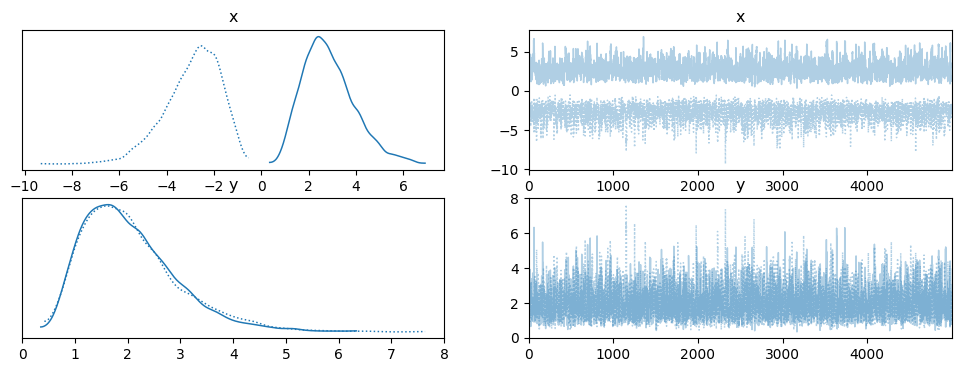

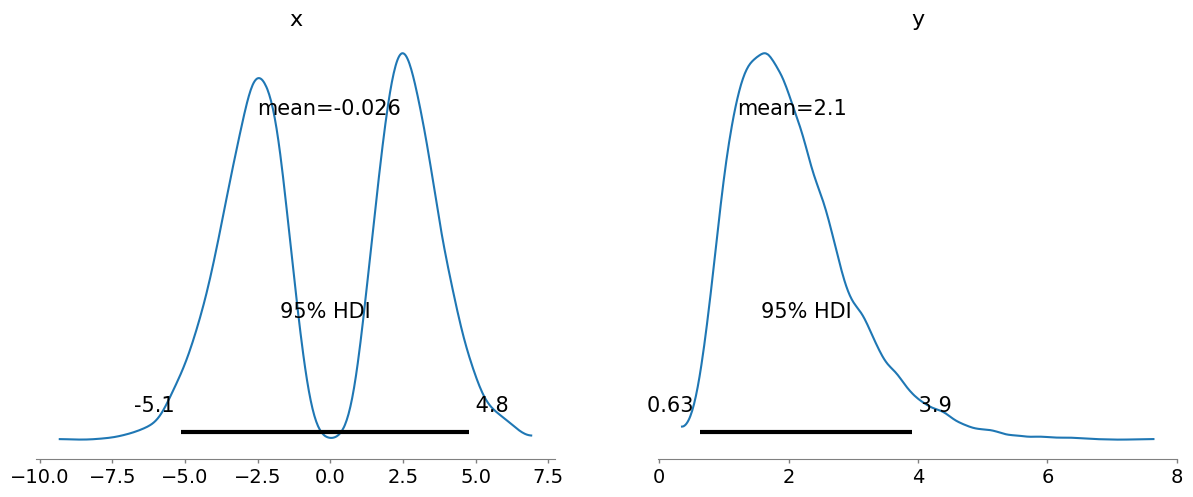

Estimated P(X >= 3 | Z = 4) = 0.1983
95% Credible Interval = [0.1906, 0.2062]


In [17]:
with pm.Model() as model3:
    # X ~ N(0, 4) với sigma=2
    x = pm.Normal("x", mu=0, sigma=2)
    # Y | X ~ Uniform(0, |x|)
    y = pm.Uniform("y", lower=0, upper=pt.abs(x))
    # Z | Y ~ Exponential(rate = 1/y) với dữ liệu quan sát Z=4
    z = pm.Exponential("z", lam=1.0/y, observed=4)

    trace3 = pm.sample(draws=5000, tune=2000, chains=2, target_accept=0.99, random_seed=42)

az.plot_trace(trace3, var_names=["x", "y"])
plt.show()

az.plot_posterior(trace3, var_names=["x", "y"], hdi_prob=0.95)
plt.show()

x_samples = trace3.posterior["x"].values.flatten()
indicator = (x_samples >= 3).astype(int)
# Số mẫu hiệu quả
N_samples = len(indicator)
# Số mẫu thoả mãn điều kiện
k = np.sum(indicator)

# Ước lượng P(X>=3|Z=4)
p_est = k / N_samples

# Tính khoảng tin cậy 95% dựa trên phân phối Beta (với prior Beta(1,1))
ci_lower = beta.ppf(0.025, k + 1, N_samples - k + 1)
ci_upper = beta.ppf(0.975, k + 1, N_samples - k + 1)

print(f"Estimated P(X >= 3 | Z = 4) = {p_est:.4f}")
print(f"95% Credible Interval = [{ci_lower:.4f}, {ci_upper:.4f}]")

# Câu 4

## Tiền xử lý dữ liệu

In [18]:
# Định nghĩa tên cột dựa trên mô tả của Auto MPG dataset
column_names = [
    "mpg",
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "model_year",
    "origin",
    "car_name",
]

df = pd.read_csv("auto-mpg.data", sep="\s+", names=column_names, na_values="?")

# Xử lý cột car_name: loại bỏ dấu ngoặc kép nếu cần
df["car_name"] = df["car_name"].str.replace('"', "")

# Chuyển đổi cột 'horsepower' sang kiểu số (float)
df["horsepower"] = pd.to_numeric(df["horsepower"], errors="coerce")

# Chuyển đổi biến 'origin': từ số sang tên vùng
origin_map = {1: "American", 2: "European", 3: "Japanese"}
df["origin"] = df["origin"].map(origin_map)

df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(2), object(2)
memory usage: 28.1+ KB


(    mpg  cylinders  displacement  horsepower  weight  acceleration  \
 0  18.0          8         307.0       130.0  3504.0          12.0   
 1  15.0          8         350.0       165.0  3693.0          11.5   
 2  18.0          8         318.0       150.0  3436.0          11.0   
 3  16.0          8         304.0       150.0  3433.0          12.0   
 4  17.0          8         302.0       140.0  3449.0          10.5   
 
    model_year    origin                   car_name  
 0          70  American  chevrolet chevelle malibu  
 1          70  American          buick skylark 320  
 2          70  American         plymouth satellite  
 3          70  American              amc rebel sst  
 4          70  American                ford torino  ,
 None)

In [19]:
df.isnull().sum()

,0
mpg,0
cylinders,0
displacement,0
horsepower,6
weight,0
acceleration,0
model_year,0
origin,0
car_name,0


Ta sẽ điền những dòng của cột horsepower bị null = mean

In [20]:
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].mean())
df.isnull().sum()


,0
mpg,0
cylinders,0
displacement,0
horsepower,0
weight,0
acceleration,0
model_year,0
origin,0
car_name,0


Trước hết, tách dữ liệu theo giá trị của cột origin để tiện cho việc xây dựng mô hình riêng cho từng nhóm.

In [21]:
df_american = df[df['origin'] == 'American']
df_european = df[df['origin'] == 'European']
df_japanese = df[df['origin'] == 'Japanese']
# Kiểm tra số lượng mẫu trong mỗi nhóm:
print("American:", df_american.shape[0])
print("European:", df_european.shape[0])
print("Japanese:", df_japanese.shape[0])

American: 249
European: 70
Japanese: 79


## 4.1 Mô hình phân phối chuẩn riêng lẻ theo từng nhóm

### 1. Giả định Phân Phối

Giả sử rằng đối với mỗi nhóm $ g $ (ví dụ: American, European, Japanese), MPG của xe có thể được mô hình hóa bằng phân phối Normal:

$$
\text{mpg}_i \sim \mathcal{N}(\mu_g, \sigma_g^2), \quad i \in g.
$$

Trong đó:
- $\mu_g$ là trung bình MPG của nhóm $g$.
- $\sigma_g$ là độ lệch chuẩn của MPG trong nhóm $g$.

### 2. Likelihood của Dữ liệu

Với tập dữ liệu $\{mpg_i\}_{i\in g}$ của nhóm $g$, hàm likelihood được xây dựng như sau:

$$
L_g(\mu_g, \sigma_g \mid \{mpg_i\}_{i \in g}) = \prod_{i \in g} \frac{1}{\sqrt{2\pi}\,\sigma_g}\,\exp\!\Bigl[-\frac{1}{2}\Bigl(\frac{mpg_i-\mu_g}{\sigma_g}\Bigr)^2\Bigr].
$$

Nếu có nhiều quan sát, likelihood chung của nhóm là tích của các hàm mật độ cho từng quan sát.

### 3. Prior Cho Các Tham Số

Chọn các tiên nghiệm "rộng" (weakly informative priors) để dữ liệu có thể chủ yếu “kéo” kết quả:
- **Cho trung bình $\mu_g$:**
  
  $$
  \mu_g \sim \mathcal{N}(0, 100^2).
  $$
  
- **Cho độ lệch chuẩn $\sigma_g$:**

  $$
  \sigma_g \sim \text{HalfNormal}(\sigma=10).
  $$

### 4. Mục Tiêu

Mục tiêu của mô hình là:
- Ước lượng các tham số $\mu_g$ và $\sigma_g$ cho mỗi nhóm riêng rẽ.
- So sánh MPG trung bình giữa các nhóm (ví dụ: so sánh $\mu_{\text{American}}$, $\mu_{\text{European}}$ và $\mu_{\text{Japanese}}$) để xác định xem có sự khác biệt đáng kể hay không.

Output()

               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_american  20.083  0.408  19.306   20.850      0.004    0.005    8889.0   
mu_european  27.880  0.835  26.299   29.449      0.009    0.011    8564.0   
mu_japanese  30.447  0.700  29.129   31.738      0.008    0.009    7170.0   

             ess_tail  r_hat  
mu_american    4656.0    1.0  
mu_european    5059.0    1.0  
mu_japanese    4779.0    1.0  


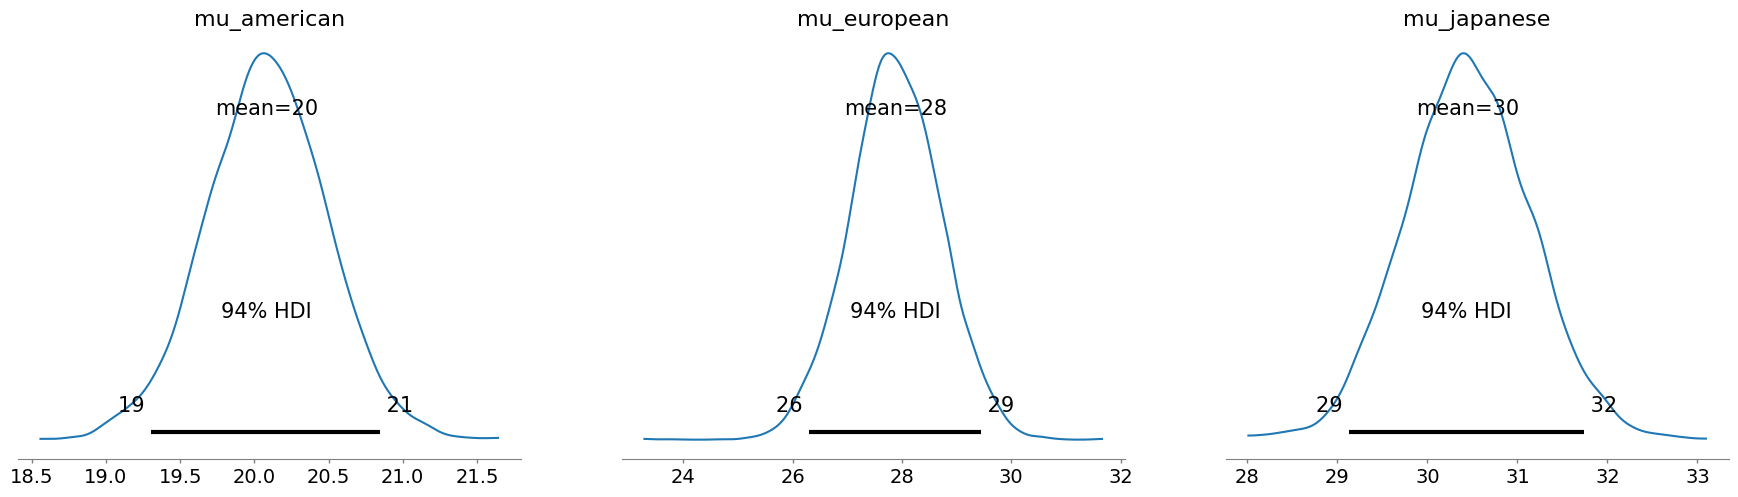

In [22]:
with pm.Model() as model_normal:
    # Priors cho nhóm American:
    mu_american = pm.Normal("mu_american", mu=0, sigma=100)
    sigma_american = pm.HalfNormal("sigma_american", sigma=10)

    # Priors cho nhóm European:
    mu_european = pm.Normal("mu_european", mu=0, sigma=100)
    sigma_european = pm.HalfNormal("sigma_european", sigma=10)

    # Priors cho nhóm Japanese:
    mu_japanese = pm.Normal("mu_japanese", mu=0, sigma=100)
    sigma_japanese = pm.HalfNormal("sigma_japanese", sigma=10)

    # Likelihood cho từng nhóm:
    like_american = pm.Normal("like_american", mu=mu_american, sigma=sigma_american,
                              observed=df_american['mpg'].values)
    like_european = pm.Normal("like_european", mu=mu_european, sigma=sigma_european,
                              observed=df_european['mpg'].values)
    like_japanese = pm.Normal("like_japanese", mu=mu_japanese, sigma=sigma_japanese,
                              observed=df_japanese['mpg'].values)

    # Lấy mẫu từ posterior:
    trace_normal = pm.sample(draws=3000, tune=1000, chains=2, random_seed=42)

# Tóm tắt kết quả:
print(az.summary(trace_normal, var_names=["mu_american", "mu_european", "mu_japanese"]))
az.plot_posterior(trace_normal, var_names=["mu_american", "mu_european", "mu_japanese"])
plt.show()


## 4.2 Mô hình phân phối student riêng lẻ cho từng nhóm

### 1. Giả định Phân Phối

Trong mô hình này, chúng ta giả định rằng với mỗi nhóm $g$ (ví dụ: American, European, Japanese), dữ liệu MPG của mỗi xe $x_i$ được mô hình hóa bởi phân phối Student’s t với các tham số:
- $\mu_g$: Trung bình MPG của nhóm $g$
- $\sigma_g$: Độ lệch chuẩn của MPG trong nhóm $g$
- $\nu$: Bậc tự do, điều chỉnh độ dày của đuôi phân phối (giá trị nhỏ hơn cho đuôi dày hơn)

Công thức hàm mật độ của phân phối Student’s t là:

$$
f(x_i \mid \mu_g, \sigma_g, \nu) = \frac{\Gamma\Bigl(\frac{\nu+1}{2}\Bigr)}{\Gamma\Bigl(\frac{\nu}{2}\Bigr)\sqrt{\nu\pi}\,\sigma_g} \left[1 + \frac{1}{\nu}\Bigl(\frac{x_i - \mu_g}{\sigma_g}\Bigr)^2 \right]^{-\frac{\nu+1}{2}}.
$$

### 2. Likelihood cho Một Nhóm

Giả sử rằng đối với nhóm $g$ (ví dụ: nhóm American), tập dữ liệu quan sát được là $\{x_1, x_2, \dots, x_{n_g}\}$. Khi đó, hàm likelihood cho nhóm này được xây dựng như sau:

$$
L(\mu_g, \sigma_g, \nu \mid \{x_i\}_{i \in g}) = \prod_{i=1}^{n_g} f(x_i \mid \mu_g, \sigma_g, \nu),
$$

với $f(x_i \mid \mu_g, \sigma_g, \nu)$ là hàm mật độ của phân phối Student’s t như đã nêu ở trên.

### 3. Prior Cho Các Tham Số

Chúng ta chọn các tiên nghiệm "rộng" (weakly informative priors) cho các tham số:
- **Cho trung bình $\mu_g$:**

  $$
  \mu_g \sim \mathcal{N}(0, 100^2)
  $$
  
  Đây là một lựa chọn phổ biến khi không có nhiều thông tin trước về giá trị trung bình.

- **Cho độ lệch chuẩn $\sigma_g$:**

  $$
  \sigma_g \sim \text{HalfNormal}(\sigma=10)
  $$
  
  Vì $\sigma_g > 0$, nên sử dụng phân phối bán chuẩn.

- **Cho bậc tự do $\nu$:**
  $$
  \nu  = 3
  $$

### 4. Mục Tiêu của Mô Hình

- Ước lượng các tham số $\mu_g$ và $\sigma_g$ cho mỗi nhóm.
- So sánh các MPG trung bình giữa các nhóm (ví dụ, so sánh $\mu_{\text{American}}$, $\mu_{\text{European}}$ và $\mu_{\text{Japanese}}$).
- Sử dụng mô hình Student T giúp kháng lại ngoại lai nhờ vào đặc tính đuôi dày của phân phối.



Output()

               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_american  18.978  0.398  18.221   19.725      0.004    0.005    8566.0   
mu_european  27.046  0.746  25.619   28.429      0.008    0.010    8306.0   
mu_japanese  30.734  0.721  29.340   32.079      0.009    0.009    7040.0   

             ess_tail  r_hat  
mu_american    5178.0    1.0  
mu_european    5174.0    1.0  
mu_japanese    4416.0    1.0  


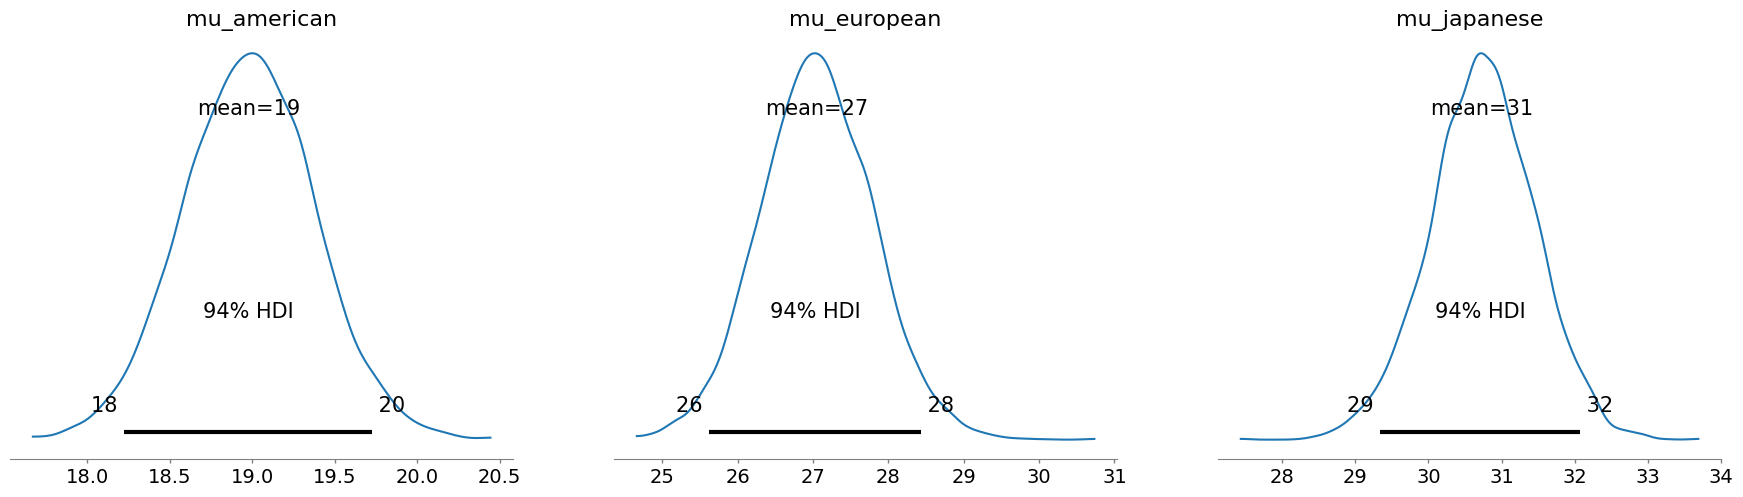

In [23]:
with pm.Model() as model_student:
    nu = 3
    mu_american = pm.Normal("mu_american", mu=0, sigma=100)
    sigma_american = pm.HalfNormal("sigma_american", sigma=10)

    mu_european = pm.Normal("mu_european", mu=0, sigma=100)
    sigma_european = pm.HalfNormal("sigma_european", sigma=10)

    mu_japanese = pm.Normal("mu_japanese", mu=0, sigma=100)
    sigma_japanese = pm.HalfNormal("sigma_japanese", sigma=10)

    like_american = pm.StudentT("like_american", nu=nu, mu=mu_american, sigma=sigma_american,
                                observed=df_american['mpg'].values)
    like_european = pm.StudentT("like_european", nu=nu, mu=mu_european, sigma=sigma_european,
                                observed=df_european['mpg'].values)
    like_japanese = pm.StudentT("like_japanese", nu=nu, mu=mu_japanese, sigma=sigma_japanese,
                                observed=df_japanese['mpg'].values)

    trace_student = pm.sample(draws=3000, tune=1000, chains=2, random_seed=42)

print(az.summary(trace_student, var_names=["mu_american", "mu_european", "mu_japanese"]))
az.plot_posterior(trace_student, var_names=["mu_american", "mu_european", "mu_japanese"])
plt.show()


## 4.3 Mô hình phân cấp (“chia sẻ thông tin nhóm”) với phân phối Student

### 1. Giả định Phân phối và Cấu trúc Mô hình

Trong mô hình phân cấp, chúng ta giả định rằng các xe thuộc các nhóm (American, European, Japanese) có MPG được mô hình hóa bởi phân phối StudentT, nhưng các trung bình của từng nhóm $\mu_g$ được “chia sẻ thông tin” qua một phân phối chung.

#### 1.1. Phân phối của MPG theo nhóm

Với mỗi nhóm $g$ (trong đó $g \in \{\text{American}, \text{European}, \text{Japanese}\}$), ta giả định rằng:

$$
\text{mpg}_i \sim t_{\nu}(\mu_g, \sigma_g), \quad i \in g,
$$

với các tham số:
- $\mu_g$: trung bình MPG của nhóm $g$,
- $\sigma_g$: độ lệch chuẩn của MPG trong nhóm $g$,
- $\nu$: bậc tự do (degree of freedom) chung cho các nhóm, kiểm soát độ dày của đuôi phân phối.

#### 1.2. Cấu trúc phân cấp cho trung bình $\mu_g$

Các trung bình của từng nhóm được cho là được rút ra từ một phân phối chung:

$$
\mu_g \sim \mathcal{N}(\mu_0, \tau^2),
$$

với:
- $\mu_0$: trung bình chung (hyperparameter),
- $\tau$: độ lệch chuẩn của phân phối chung, đo lường mức độ khác biệt giữa các nhóm.

#### 1.3. Prior cho các tham số

Chúng ta chọn các tiên nghiệm "rộng" (weakly informative) như sau:

- **Hyperpriors:**
  - $\mu_0 \sim \mathcal{N}(0, 100^2)$
  - $\tau \sim \text{HalfNormal}(\sigma=10)$
- **Prior cho bậc tự do:**
  - $\nu \sim \text{Exponential}(1/10)$ (đảm bảo $\nu>0$)
- **Prior cho từng nhóm:**
  - $\mu_g \sim \mathcal{N}(\mu_0, \tau^2)$
  - $\sigma_g \sim \text{HalfNormal}(\sigma=10)$

### 2. Likelihood của dữ liệu

Với mỗi nhóm \(g\), likelihood cho các quan sát $\{mpg_i\}_{i \in g}$ được mô tả bởi hàm mật độ của phân phối StudentT:

$$
f(\text{mpg}_i \mid \mu_g, \sigma_g, \nu) = \frac{\Gamma\Bigl(\frac{\nu+1}{2}\Bigr)}{\Gamma\Bigl(\frac{\nu}{2}\Bigr)\sqrt{\nu\pi}\,\sigma_g} \left[1 + \frac{1}{\nu}\left(\frac{\text{mpg}_i-\mu_g}{\sigma_g}\right)^2\right]^{-\frac{\nu+1}{2}}.
$$

Giả sử các nhóm có dữ liệu độc lập, likelihood chung của mô hình là tích của các likelihood riêng theo từng nhóm.

### 3. Mục tiêu của mô hình

- **Ước lượng:**  
  ước lượng các tham số $\mu_0$, $\tau$, và các $\mu_g$ cho từng nhóm cùng với độ lệch chuẩn $\sigma_g$ và bậc tự do $\nu$.

- **So sánh:**  
  so sánh MPG trung bình giữa các nhóm (American, European, Japanese) thông qua các tham số $\mu_g$.

- **Ưu điểm của mô hình phân cấp:**  
  Khi một số nhóm có số lượng mẫu ít, mô hình phân cấp giúp “chia sẻ thông tin” qua hyperpriors, từ đó cho kết quả ổn định và chính xác hơn.

Output()

ERROR:pymc.stats.convergence:There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu0          26.020  5.031  16.877   36.140      0.077    0.125    4858.0   
mu_american  19.841  0.429  19.042   20.672      0.005    0.006    7655.0   
mu_european  27.618  0.815  26.151   29.178      0.009    0.011    9059.0   
mu_japanese  30.401  0.696  29.083   31.666      0.008    0.010    7184.0   

             ess_tail  r_hat  
mu0            2846.0    1.0  
mu_american    4494.0    1.0  
mu_european    4439.0    1.0  
mu_japanese    4112.0    1.0  


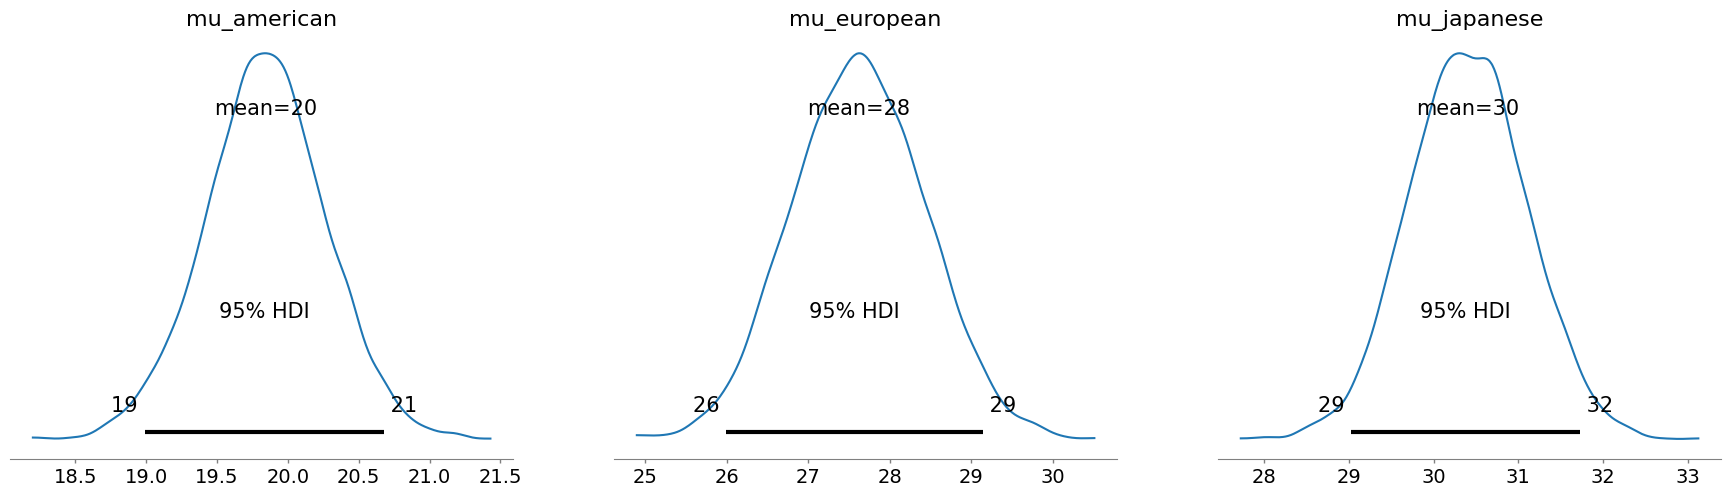

In [24]:
with pm.Model() as model_hierarchical:
    # Hyperpriors chung:
    mu0 = pm.Normal("mu0", mu=0, sigma=100)
    tau = pm.HalfNormal("tau", sigma=10)

    # Hyperprior cho nu (bậc tự do) – có thể chung cho tất cả
    nu = pm.Exponential("nu", 1/10)

    # Priors cho từng nhóm với μ được chia sẻ thông tin:
    mu_american = pm.Normal("mu_american", mu=mu0, sigma=tau)
    sigma_american = pm.HalfNormal("sigma_american", sigma=10)

    mu_european = pm.Normal("mu_european", mu=mu0, sigma=tau)
    sigma_european = pm.HalfNormal("sigma_european", sigma=10)

    mu_japanese = pm.Normal("mu_japanese", mu=mu0, sigma=tau)
    sigma_japanese = pm.HalfNormal("sigma_japanese", sigma=10)

    # Likelihood sử dụng StudentT cho từng nhóm:
    like_american = pm.StudentT("like_american", nu=nu, mu=mu_american, sigma=sigma_american,
                                observed=df_american['mpg'].values)
    like_european = pm.StudentT("like_european", nu=nu, mu=mu_european, sigma=sigma_european,
                                observed=df_european['mpg'].values)
    like_japanese = pm.StudentT("like_japanese", nu=nu, mu=mu_japanese, sigma=sigma_japanese,
                                observed=df_japanese['mpg'].values)

    trace_hierarchical = pm.sample(draws=3000, tune=1000, chains=2, random_seed=42)

print(az.summary(trace_hierarchical, var_names=["mu0", "mu_american", "mu_european", "mu_japanese"]))
az.plot_posterior(trace_hierarchical, var_names=["mu_american", "mu_european", "mu_japanese"], hdi_prob=0.95)
plt.show()


## **Tổng kết**:
### 1.Mô hình phân phối chuẩn riêng lẻ theo từng nhóm
- American:
  - Ước lượng trung bình MPG: khoảng 20
  - Khoảng HDI 94%: khoảng $[19.306,20.850]$
- European:
  - Ước lượng trung bình MPG: khoảng 28
  - Khoảng HDI 94%: khoảng $[26.299,29.449]$
- Japanese:
  - Ước lượng trung bình MPG: khoảng 30
  - Khoảng HDI 94%: khoảng $[29.129,31.738]$

### 2.StudentT Riêng Rẽ
- American:
  - Ước lượng trung bình MPG: khoảng 19
  - Khoảng HDI 94%: khoảng $[18.221   ,19.725]$
- European:
  - Ước lượng trung bình MPG: khoảng 27
  - Khoảng HDI 94%: khoảng $[25.619   ,28.429]$
- Japanese:
  - Ước lượng trung bình MPG: khoảng 31
  - Khoảng HDI 94%: khoảng $[29.340   ,32.079]$

### 3.Phân cấp với StudentT (Hierarchical Model)
- American:
  - Ước lượng trung bình MPG: khoảng 20
  - Khoảng HDI 95%: khoảng $[19.042   ,20.672]$
- European:
  - Ước lượng trung bình MPG: khoảng 28
  - Khoảng HDI 95%: khoảng $[26.151   ,29.178]$
- Japanese:
  - Ước lượng trung bình MPG: khoảng 30
  - Khoảng HDI 95%: khoảng $[29.083   ,31.666]$

## **Nhận xét chung :**
- Thứ tự MPG trung bình giữa các nhóm được ước lượng ở cả 3 mô hình đều nhất quán, đó là:
American < European < Japanese.
- Mô hình Normal (Model 1) cho kết quả ổn định đối với nhóm có số lượng mẫu lớn (American), nhưng có thể bị ảnh hưởng bởi ngoại lai đối với các nhóm khác.
- Mô hình StudentT Riêng Rẽ (Model 2) giúp kháng ngoại lai tốt hơn (đặc biệt nếu có những giá trị MPG bất thường), nhưng vì không “chia sẻ thông tin” giữa các nhóm, nhóm có dữ liệu ít (European, Japanese) có thể cho khoảng tin cậy rộng hơn.
- Mô hình Phân cấp với StudentT (Model 3) kết hợp ưu điểm của mô hình StudentT (kháng ngoại lai) và mô hình phân cấp (chia sẻ thông tin giữa các nhóm). Điều này cho phép các nhóm có số lượng mẫu nhỏ (như European và Japanese) được “kéo” về giá trị chung và có khoảng tin cậy ổn định hơn.  


## **Kết luận :**
Mô hình Phân cấp với StudentT (Model 3) được đánh giá là lựa chọn tốt nhất cho bài toán này vì:
- Nó cho phép chia sẻ thông tin giữa các nhóm, giúp ước lượng trở nên ổn định hơn đối với các nhóm có số mẫu nhỏ.
- Sử dụng StudentT giúp kháng ngoại lai, đảm bảo kết quả không bị ảnh hưởng quá mức bởi các giá trị bất thường.
- Kết quả của mô hình phân cấp (Model 3) cho các giá trị trung bình MPG:
  - American $≈ 20$ Khoảng HDI 95%: khoảng $[19.042   ,20.672]$
  - European $≈ 28$ Khoảng HDI 95%: khoảng $[26.151   ,29.178]$
  - Japanese $≈ 30$ Khoảng HDI 95%: khoảng $[29.083   ,31.666]$